# GAIA to TESS

In [87]:
import lightkurve as lk
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle

import sys
sys.path
sys.path.append('./dave/diffimg/')
import tessprf as prf
from scipy import interpolate
from scipy import signal

In [96]:
def Get_TESS(RA,DEC,Size,Sector=None):
    c = SkyCoord(ra=float(RA)*u.degree, dec=float(DEC) *
                 u.degree, frame='icrs')
    
    tess = lk.search_tesscut(c,sector=Sector)
    tpf = tess.download(cutout_size=Size)
    
    return tpf

def Downsample(PSconv):
	"""
	Downsamples the PS image to the resolution of TESS.
	Inputs
    ------
    PSconv: array like
    	The PS image convolved with the TESS PSF
	Returns
	-------
	TESS_resolution: array like
		The PS image reduced to the TESS resolution
	"""
	PSpixel = 0.021 # arcseconds per pixel 
	TESSpixel = 21 # arcseconds per pixel 
	Scale = 100#TESSpixel/PSpixel
	xnew = np.arange(PSconv.shape[1]/Scale)
	ynew = np.arange(PSconv.shape[0]/Scale)
	TESS_resolution = np.zeros((int(PSconv.shape[0]/Scale),int(PSconv.shape[1]/Scale)))
	for i in range(len(ynew)-1):
		ystart = int(i*Scale)
		yend = int(ystart + Scale)
		for j in range(len(xnew)-1):
			xstart = int(j*Scale)
			xend = int(xstart + Scale)
			TESS_resolution[i,j] = np.nansum(PSconv[ystart:yend,xstart:xend])
	return TESS_resolution

In [68]:
def Interp_PRF(Row,Col,Camera,CCD):
    pathToMatFile = './data/prf/'
    obj = prf.TessPrf(pathToMatFile)
    PRF = obj.getPrfAtColRow(Row, Col, 1,Camera,CCD)
    x2 = np.arange(0,PRF.shape[1]-1,0.01)
    y2 = np.arange(0,PRF.shape[0]-1,0.01)

    x = np.arange(0,PRF.shape[1],1)
    y = np.arange(0,PRF.shape[0],1)
    X, Y = np.meshgrid(x,y)

    x=X.ravel()              #Flat input into 1d vector
    y=Y.ravel()

    z = PRF
    z = z.ravel()
    x = list(x[np.isfinite(z)])
    y = list(y[np.isfinite(z)])
    z = list(z[np.isfinite(z)])

    znew = interpolate.griddata((x, y), z, (x2[None,:], y2[:,None]), method='cubic')
    kernal = znew
    return kernal

def Gaia(tpf, magnitude_limit = 18):
    c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
    # Use pixel scale for query size
    pix_scale = 4.0  # arcseconds / pixel for Kepler, default
    if tpf.mission == 'TESS':
        pix_scale = 21.0
    # We are querying with a diameter as the radius, overfilling by 2x.
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    result = Vizier.query_region(c1, catalog=["I/345/gaia2"],
                                 radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise too_few_found_message
    result = result["I/345/gaia2"].to_pandas()
    
    result = result[result.Gmag < magnitude_limit]
    if len(result) == 0:
        raise no_targets_found_message
    radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
    coords = tpf.wcs.all_world2pix(radecs, 1) ## TODO, is origin supposed to be zero or one?
    Gmag = result['Gmag'].values
    #Jmag = result['Jmag']
    ind = (((coords[:,0] >= 0) & (coords[:,1] >= 0)) & 
           ((coords[:,0] < tpf.shape[1]-1) & (coords[:,1] < tpf.shape[2]-1)))
    coords = coords[ind]
    Gmag = Gmag[ind]
    #Jmag = Jmag[ind]
    return coords, Gmag

In [10]:
tpf = Get_TESS(336,47,20)

In [44]:
pos, gmag = Gaia(tpf)

<IPython.core.display.Javascript object>


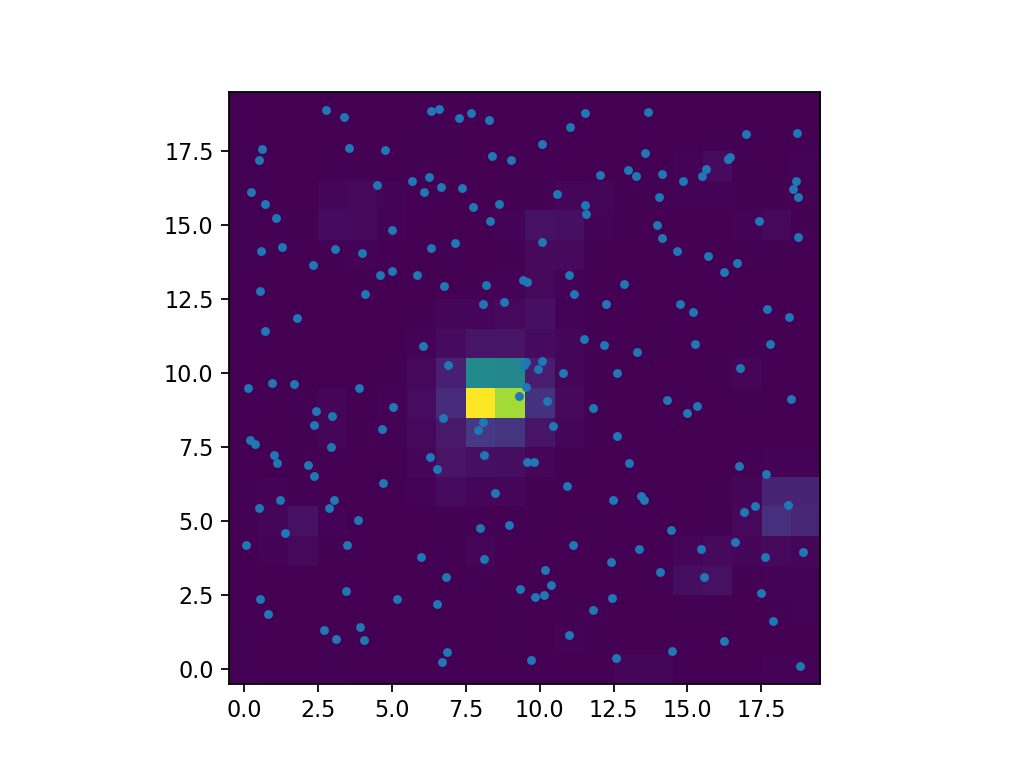

In [34]:
plt.figure()
plt.imshow(tpf.flux[100],origin='lower')
plt.plot(pos[:,0],pos[:,1],'.')

In [100]:
def GAIA_scene(Ra,Dec,Size):
    tpf = Get_TESS(Ra,Dec,Size)
    pos, gmag = Gaia(tpf)
    Tmag = gmag - 0.5
    tcounts = 10**(-2/5*(Tmag - 20.44))
    sources = np.zeros((len(pos),tpf.shape[1],tpf.shape[2]))
    for i in range(len(pos)):
        template = np.zeros((tpf.shape[1]*100,tpf.shape[2]*100))
        kernal = Interp_PRF(pos[i,0] + tpf.row, pos[i,1] + tpf.column,tpf.camera,tpf.ccd) # check row and column are right
        print(template.shape)
        
        template[int(pos[i,0]*100),int(pos[i,1]*100)] = tcounts[i]
        template = signal.fftconvolve(template, kernal, mode='same')
        sources[i] = Downsample(template)
    return sources 
        
        
        

In [101]:
test = GAIA_scene(336,47,20)

(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)

In [114]:
from scipy.ndimage import  rotate
from astropy.visualization import (SqrtStretch, ImageNormalize)

<IPython.core.display.Javascript object>


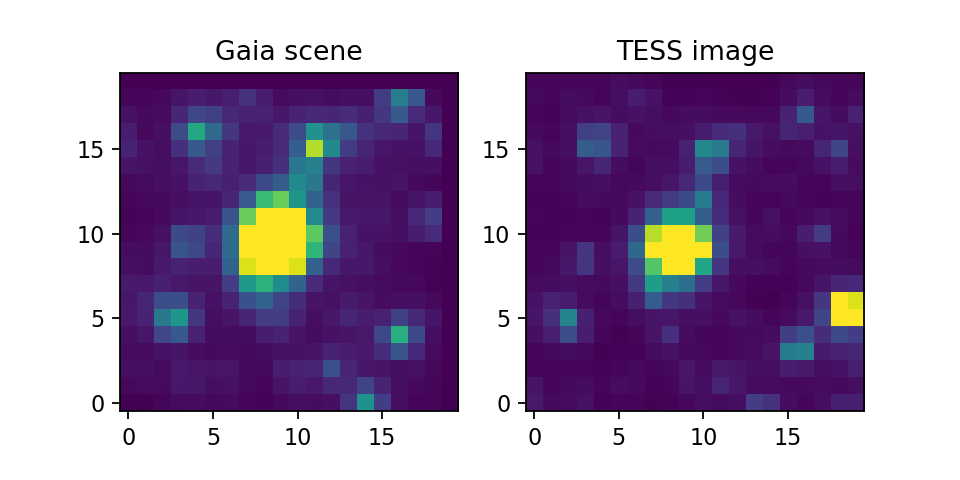

In [118]:
gaia = np.nansum(test,axis=0)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Gaia scene')
plt.imshow(rotate(np.flipud(gaia/np.nanmax(gaia)),-90),origin='lower',vmax=0.05)
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tpf.flux[0]/np.nanmax(tpf.flux[0]),origin='lower',vmax=0.1)
plt.savefig('gaia_scene.png')

In [91]:
sources = np.zeros((len(pos),tpf.shape[1],tpf.shape[2]))

In [92]:
sources.shape

(196, 20, 20)

In [99]:
Downsample(test).shape

(20, 20)

<IPython.core.display.Javascript object>


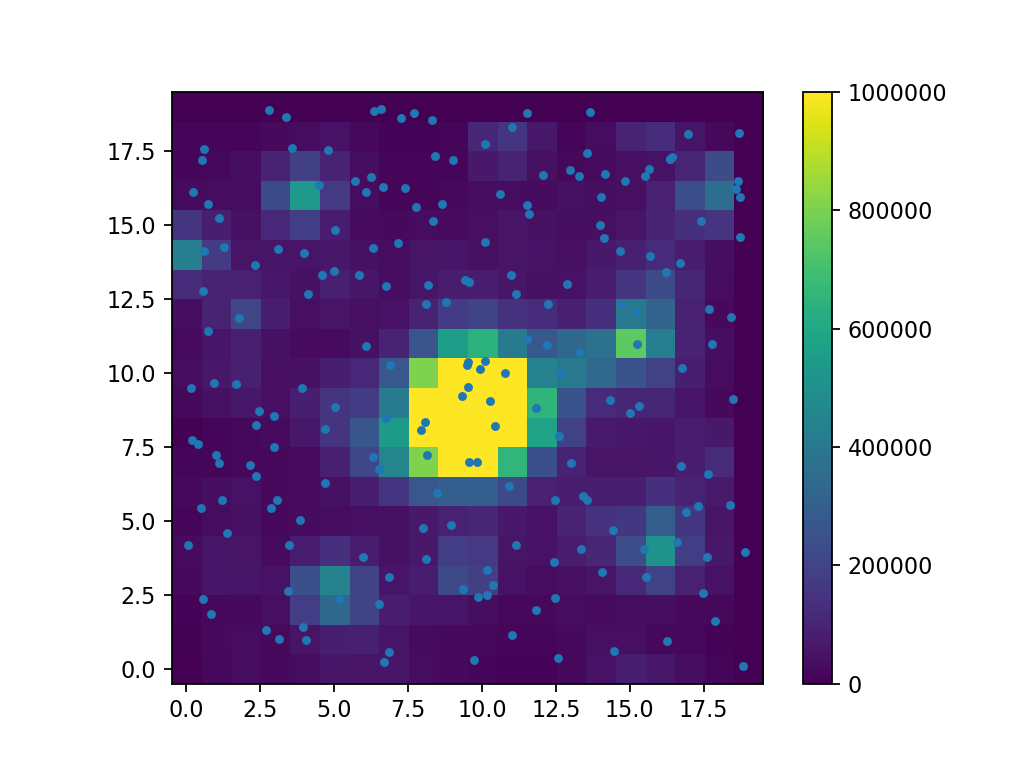

In [112]:
plt.figure()
plt.imshow(c,origin='lower',vmax=1000000)
plt.colorbar()
plt.plot(pos[:,0],pos[:,1],'.')